<a href="https://colab.research.google.com/github/Dhivyagkrishnan/QLSTM_for_stock_analysis/blob/main/LSTM_AAPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:

!pip install utils
!pip install mxnet

In [81]:
import helper
import pandas as pd
from utils import *

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from IPython.display import Image

In [83]:
df = pd.read_csv('dataset_AAPL_prediction.csv')
df = df.drop(['Date' ,'Unnamed: 0'], axis=1)
df

,Close,High,Low,Open,Volume,Ticker,FT3,FT6,FT9,ARIMA,...,SPY,AMZN,NVDA,TSLA,META,INTC,ADBE,NYSE,NASDAQ,Close_lead1
0,87.918793,88.013573,85.367111,85.845856,130646000,AAPL,164.406568,149.935408,145.477595,87.918793,...,283.488220,134.018997,9.169775,67.290001,219.436157,51.944389,424.200012,11777.080078,9874.150391,88.652687
1,88.652687,88.939453,87.486207,87.505645,140223200,AAPL,163.840928,148.959016,144.074346,88.652687,...,287.119568,137.940994,9.466547,71.987335,225.831070,53.335041,435.309998,11893.780273,10058.769531,88.485039
2,88.485039,89.274845,88.436440,88.730489,110737200,AAPL,163.275905,147.990596,142.686206,88.485039,...,289.130768,143.934998,9.498687,74.641998,236.253891,52.425766,439.809998,11901.549805,10154.629883,88.485039
3,88.485039,90.030633,88.370828,89.393929,114041600,AAPL,162.711560,147.030407,141.314007,88.485039,...,290.723053,144.514999,9.580671,80.577332,232.146423,52.711037,442.950012,11991.519531,10207.629883,90.852005
4,90.852005,91.321027,89.884794,89.916387,118655600,AAPL,162.147954,146.078704,139.958564,90.852005,...,295.210999,152.852005,9.806925,91.438667,238.968994,53.076527,452.589996,12160.009766,10433.650391,90.570107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250,201.000000,201.699997,196.860001,198.240005,96813500,AAPL,167.809872,155.946161,154.166099,196.494189,...,594.280029,209.690002,143.850006,322.160004,682.349976,21.080000,376.920013,19868.359375,19447.410156,201.500000
1251,201.500000,202.300003,198.960007,201.630005,55814300,AAPL,167.241837,154.927598,152.690407,201.202717,...,600.150024,208.470001,144.169998,348.679993,698.530029,21.190001,380.119995,20008.179688,19630.970703,200.300003
1252,200.300003,203.440002,200.199997,202.589996,54064000,AAPL,166.674047,153.915371,151.224562,201.628095,...,606.780029,212.770004,147.899994,340.470001,712.200012,22.549999,382.339996,20217.339844,19912.529297,201.559998
1253,201.559998,203.669998,200.619995,201.449997,39525700,AAPL,166.106563,152.909762,149.769469,200.088599,...,607.119995,211.990005,154.309998,327.549988,708.679993,22.200001,387.549988,20087.449219,19973.550781,201.000000


In [84]:
target = "Close_lead1"

In [85]:
features = list(df.columns.difference(["Close", 'Close_lead1']))
features

['ADBE',
 'AMZN',
 'ARIMA',
 'FT3',
 'FT6',
 'FT9',
 'GOOG',
 'High',
 'INTC',
 'Low',
 'META',
 'MSFT',
 'NASDAQ',
 'NVDA',
 'NYSE',
 'Open',
 'QQQ',
 'SNP',
 'SPY',
 'TSLA',
 'Ticker',
 'Volume']

 DATA PROCESSING

In [86]:
size = int(len(df) * 0.67)

df_train = df.loc[:size].copy()
df_test = df.loc[size:].copy()

In [88]:
 # Identify only numeric columns (excluding the target for now)
numeric_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()

# Normalize numeric columns in both train and test
for c in numeric_cols:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev  # Use train stats for test set normalization


In [89]:
# Include target if needed
numeric_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()

for c in numeric_cols:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev


In [90]:
print(df_train.dtypes)


Close          float64
High           float64
Low            float64
Open           float64
Volume         float64
Ticker          object
FT3            float64
FT6            float64
FT9            float64
ARIMA          float64
SNP            float64
MSFT           float64
GOOG           float64
QQQ            float64
SPY            float64
AMZN           float64
NVDA           float64
TSLA           float64
META           float64
INTC           float64
ADBE           float64
NYSE           float64
NASDAQ         float64
Close_lead1    float64
dtype: object


In [91]:
df_train = df_train.select_dtypes(include=[np.number])
df_test = df_test.select_dtypes(include=[np.number])


In [92]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [93]:
from Factory import SequenceDataset

In [95]:
 import torch
from torch.utils.data import DataLoader

# ✅ Rebuild feature list from df_train after cleaning/dropping object columns
features = [col for col in df_train.columns if col != target and df_train[col].dtype in ['float64', 'int64']]

# ✅ Set random seed
torch.manual_seed(101)

# ✅ Parameters
batch_size = 1
sequence_length = 3

# ✅ Create datasets
train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

# ✅ Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ✅ Sample output for shape check
X, y = next(iter(train_loader))
print("✅ Features shape:", X.shape)
print("✅ Target shape:", y.shape)


✅ Features shape: torch.Size([1, 3, 22])
✅ Target shape: torch.Size([1])


CLASSICAL LSTM


In [96]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

In [97]:
from Factory import ShallowRegressionLSTM

In [98]:

learning_rate = 0.0001
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [99]:
classical_loss_train = []
classical_loss_test = []
print("Untrained test\n--------")
test_loss = test_model(test_loader, model, loss_function)
print()
classical_loss_test.append(test_loss)

for ix_epoch in range(20):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    print()
    classical_loss_train.append(train_loss)
    classical_loss_test.append(test_loss)

Untrained test
--------
Test loss: 6.722626046028482

Epoch 0
---------
Train loss: 0.6866374431379197
Test loss: 5.263712991545179

Epoch 1
---------
Train loss: 0.1763462879554754
Test loss: 4.2581966594218805

Epoch 2
---------
Train loss: 0.0705195173638602
Test loss: 3.579584458288793

Epoch 3
---------
Train loss: 0.05217679873313087
Test loss: 3.3221800066303966

Epoch 4
---------
Train loss: 0.0426051636480094
Test loss: 2.9233741906406525

Epoch 5
---------
Train loss: 0.0353543847872831
Test loss: 2.5704610687579086

Epoch 6
---------
Train loss: 0.03065014657873766
Test loss: 2.4390415864583215

Epoch 7
---------
Train loss: 0.027352986275809944
Test loss: 2.4762381241476783

Epoch 8
---------
Train loss: 0.0249095976192384
Test loss: 2.5206535002624677

Epoch 9
---------
Train loss: 0.023082577012928696
Test loss: 2.4718166604195755

Epoch 10
---------
Train loss: 0.02194502287398689
Test loss: 2.4540638198568714

Epoch 11
---------
Train loss: 0.020909067732947005
Test los

In [100]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output

In [101]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

      Close_lead1  Model forecast
0       -2.481063       -2.461571
1       -2.488373       -2.446253
2       -2.488373       -2.430277
3       -2.385162       -2.412596
4       -2.397454       -2.379621
...           ...             ...
1250     2.439624        1.464962
1251     2.387298        1.471797
1252     2.442240        1.479665
1253     2.417821        1.484509
1254     2.421310        1.477632

[1256 rows x 2 columns]


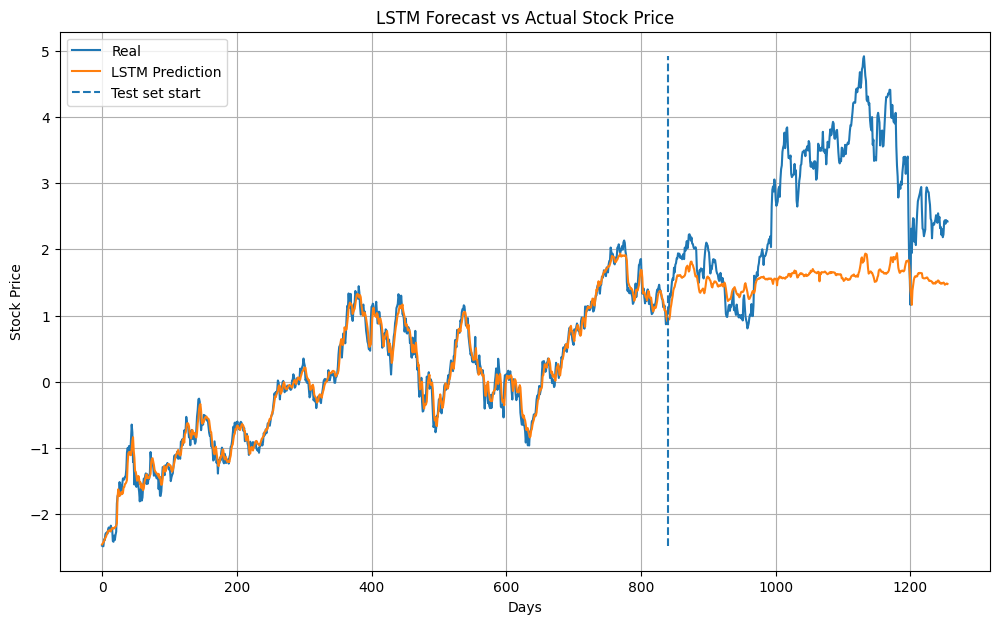

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# Auto-match length of df_out
plt.plot(range(len(df_out)), df_out["Close_lead1"], label="Real")
plt.plot(range(len(df_out)), df_out["Model forecast"], label="LSTM Prediction")

plt.ylabel('Stock Price')
plt.xlabel('Days')

# Add vertical line at correct test set start if `size` is valid
if 'size' in locals() and isinstance(size, int) and size < len(df_out):
    plt.vlines(size, ymin=min(df_out["Close_lead1"].min(), df_out["Model forecast"].min()),
               ymax=max(df_out["Close_lead1"].max(), df_out["Model forecast"].max()),
               label="Test set start", linestyles="dashed")

plt.legend()
plt.grid(True)
plt.title("LSTM Forecast vs Actual Stock Price")
plt.show()


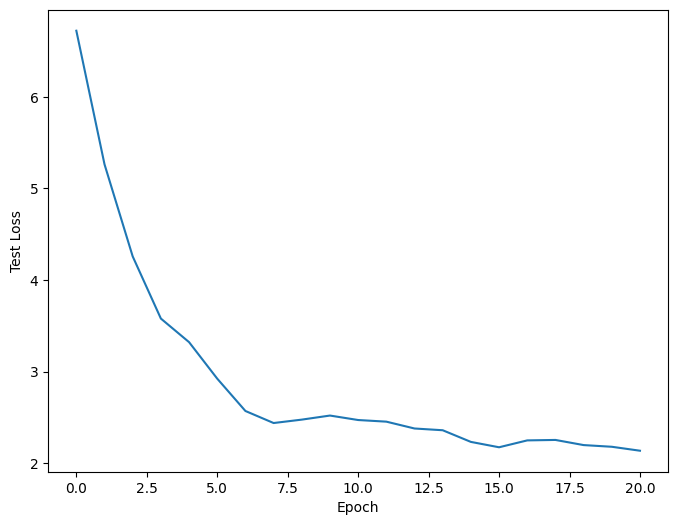

In [104]:
plt.figure(figsize=(8, 6))
plt.plot(range(21), classical_loss_test)
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.show()

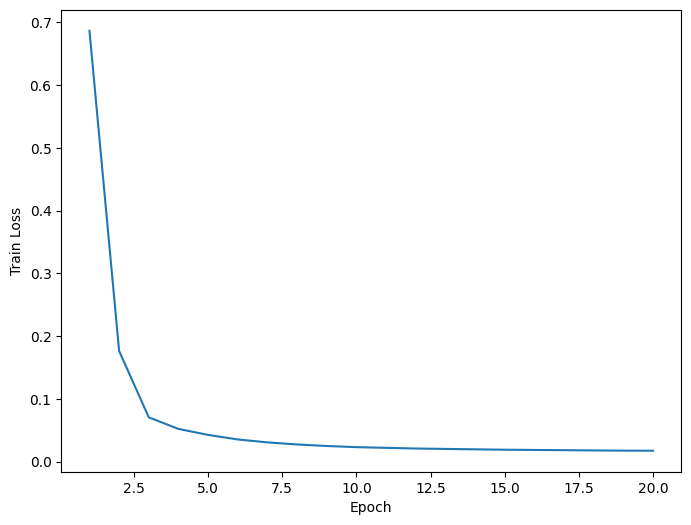

In [105]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), classical_loss_train)
plt.ylabel('Train Loss')
plt.xlabel('Epoch')
plt.show()